# Computer Vision - Task 3 (T1G2)

If you are running this notebook in your local machine:
1. create a new empty folder called content
2. unzip '02 - tagged1.zip'
3. move photos and renders folders into content folder
4. add 'train_test_split.csv' file into content folder as well

If you are running this notebook in Google Colab:
1. add these files to your Google Drive storage
    - '02 - tagged1.zip'
    - 'train_test_split.csv'

#### Libraries

In [1]:
# import libraries

import os
import cv2
import torch
import torchvision

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from xml.etree import ElementTree as ET
from collections import Counter
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from tqdm import tqdm
from torchvision.transforms import functional as F
from PIL import Image

%pip install torchmetrics
from torchmetrics.detection import MeanAveragePrecision

%pip install ultralytics
from ultralytics import YOLO
from ultralytics.data.annotator import auto_annotate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 4.0 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

In [2]:
def in_colab():
    '''
    Check if the code is running on Google Colab
    '''
    try:
        import google.colab
        return True
    except ImportError:
        return False

In [3]:
if in_colab():
    from google.colab import drive

# LEGO Detection

#### Data preparation

In [4]:
# possible strategies

cut_remaining = 100
apply_augmentation = True

In [5]:
# mount drive on colab notebook

if in_colab():
    drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# unzip data files

if in_colab():
    !unzip "/content/drive/MyDrive/02 - tagged1.zip" -d "/content"

A saída de streaming foi truncada nas últimas 5000 linhas.
  inflating: /content/renders/1/44570_Medium-Yellowish-green_5_1588263428.jpg  
  inflating: /content/renders/1/3066_White_1_1608402843.jpg  
  inflating: /content/renders/1/54383_Sand-Green_1_1588678909.jpg  
  inflating: /content/renders/1/4070_Light-Stone-Grey_8_1588631206.jpg  
  inflating: /content/renders/1/11399_Sand-Green_3_1587328912.jpg  
  inflating: /content/renders/1/99206_Medium-Yellowish-green_2_1587787565.jpg  
  inflating: /content/renders/1/2419_Spring-Yellowish-Green_7_1587826329.jpg  
  inflating: /content/renders/1/11211_Earth-Blue_0_1608628084.jpg  
  inflating: /content/renders/1/2419_Bright-Yellow_9_1588559103.jpg  
  inflating: /content/renders/1/3031_Earth-Green_3_1589236204.jpg  
  inflating: /content/renders/1/54384_Aqua_5_1589279145.jpg  
  inflating: /content/renders/1/6565_Bright-Red_1_1608931367.jpg  
  inflating: /content/renders/1/64799_Nougat_4_1587600029.jpg  
  inflating: /content/renders/1/

In [7]:
# data directories

photos_dir = '/content/photos' if in_colab() else 'content/photos'
renders_dir = '/content/renders' if in_colab() else 'content/renders'
split_path = '/content/drive/MyDrive/train_test_split.csv' if in_colab() else 'content/train_test_split.csv'

In [8]:
def load_data(data_dir):
    '''
    Returns a list of images and labels for each image
    '''
    image_paths = []
    num_legos = []
    for subdir, _, files in os.walk(data_dir):
        for file in files:
            if file.endswith('.jpg'):
                n = int(subdir.split(os.sep)[-1])
                image_paths.append(os.path.join(subdir, file))
                num_legos.append(n)
    combined = list(zip(image_paths, num_legos))
    combined.sort()
    image_paths, num_legos = zip(*combined)
    image_paths = np.asarray(image_paths)
    num_legos = torch.Tensor(num_legos).to(torch.int64)
    return image_paths, num_legos

In [9]:
def parse_xml(xml_file):
    '''
    Read the xml file and return the bounding box coordinates
    '''
    tree = ET.parse(xml_file)
    root = tree.getroot()
    bounding_boxes = []
    for obj in root.findall('object'):
        bbox = obj.find('bndbox')
        xmin = int(bbox.find('xmin').text)
        ymin = int(bbox.find('ymin').text)
        xmax = int(bbox.find('xmax').text)
        ymax = int(bbox.find('ymax').text)
        bounding_boxes.append([xmin, ymin, xmax, ymax])
    return bounding_boxes

In [10]:
def parse_all_xml(image_paths):
    '''
    Parse all XML files corresponding to the given image paths.
    '''
    bounding_boxes = []
    for img_path in image_paths:
        xml_path = img_path.replace('.jpg', '.xml')
        bounding_boxes.append(parse_xml(xml_path))
    return bounding_boxes

In [11]:
# load data

image_paths, num_legos = load_data(photos_dir)

In [12]:
# parse bounding boxes for all images

bounding_boxes = parse_all_xml(image_paths)

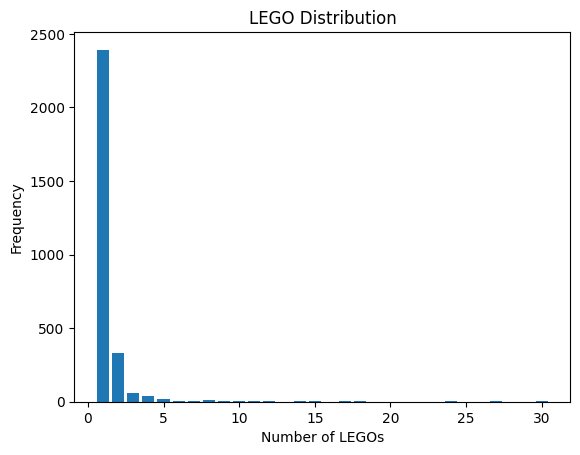

In [13]:
# class distribution in overall data

plt.hist(num_legos, bins=range(1, max(num_legos)), align='left', rwidth=0.8)
plt.xlabel('Number of LEGOs')
plt.ylabel('Frequency')
plt.title('LEGO Distribution')
plt.show()

In [14]:
# work with defined train test split

train_test_split = np.genfromtxt(split_path, delimiter=',', dtype=None, encoding=None)

train_test_ids = {
    'train': [],
    'test': []
}
for index, row in enumerate(train_test_split):
    if row[1] == '1':
      train_test_ids['test'].append(index - 1)
    elif row[1] == '0':
      train_test_ids['train'].append(index - 1)

len(train_test_ids['train']), len(train_test_ids['test'])

(2659, 274)

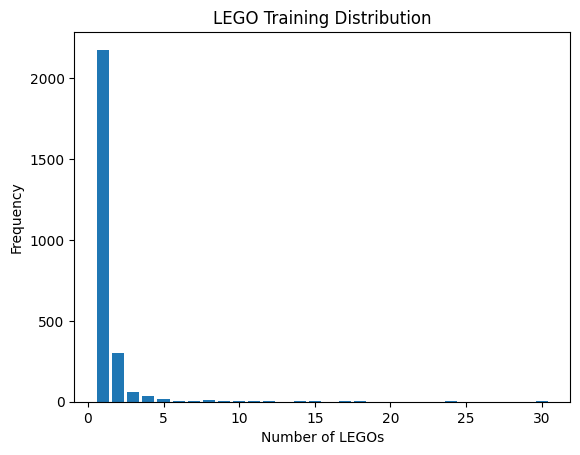

In [15]:
# class distribution in training data

num_legos_train = num_legos[train_test_ids['train']]
plt.hist(num_legos_train, bins=range(1, max(num_legos_train)), align='left', rwidth=0.8)
plt.xlabel('Number of LEGOs')
plt.ylabel('Frequency')
plt.title('LEGO Training Distribution')
plt.show()

In [16]:
# validation and test sets

num_legos_test = num_legos[train_test_ids['test']].numpy()
test_ids = train_test_ids['test']
test_distribution = Counter(num_legos_test)
set1_ids, set2_ids = [], []

for cls, count in test_distribution.items():
    cls_ids = [test_ids[i] for i in range(len(test_ids)) if num_legos_test[i] == cls]
    half_count = count // 2
    remainder = count % 2
    set1_ids.extend(cls_ids[:half_count])
    set2_ids.extend(cls_ids[half_count:half_count*2])
    if remainder:
        if len(set1_ids) <= len(set2_ids):
            set1_ids.append(cls_ids[-1])
        else:
            set2_ids.append(cls_ids[-1])

train_test_ids['test'] = np.array(set1_ids)
train_test_ids['valid'] = np.array(set2_ids)

In [17]:
# class distribution in validation and test data

num_legos_valid = num_legos[train_test_ids['valid']].numpy()
num_legos_test = num_legos[train_test_ids['test']].numpy()

valid_distribution = Counter(num_legos_valid)
test_distribution = Counter(num_legos_test)

print("Valid length:", len(train_test_ids['valid']))
print("Test length:", len(train_test_ids['test']))

print("\nValid class distribution:")
for cls, count in valid_distribution.items():
    print(f"Class {cls}: {count}")

print("\nTest class distribution:")
for cls, count in test_distribution.items():
    print(f"Class {cls}: {count}")

Valid length: 137
Test length: 137

Valid class distribution:
Class 1: 107
Class 10: 1
Class 14: 1
Class 16: 1
Class 18: 1
Class 2: 15
Class 20: 1
Class 26: 1
Class 27: 1
Class 3: 2
Class 4: 3
Class 5: 1
Class 6: 1
Class 8: 1

Test class distribution:
Class 1: 108
Class 10: 1
Class 15: 1
Class 18: 2
Class 2: 15
Class 25: 1
Class 27: 2
Class 3: 1
Class 4: 4
Class 5: 1
Class 7: 1


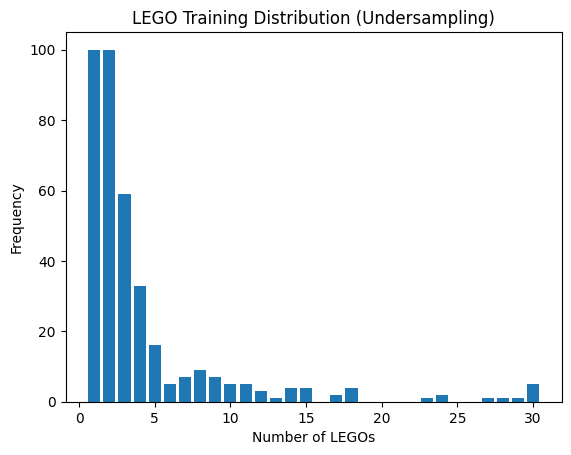

In [18]:
# undersampling of larger classes in training data

indices1 = []
indices2 = []

for i in train_test_ids['train']:
    if num_legos[i] == 1:
        indices1.append(i)
    elif num_legos[i] == 2:
        indices2.append(i)

np.random.shuffle(indices1, )
np.random.shuffle(indices2, )

leftovers1 = indices1[cut_remaining:]
leftovers2 = indices2[cut_remaining:]

for i in leftovers1:
    train_test_ids['train'].remove(i)
for i in leftovers2:
    train_test_ids['train'].remove(i)

num_legos_train = num_legos[train_test_ids['train']]
plt.hist(num_legos_train, bins=range(1, max(num_legos_train)), align='left', rwidth=0.8)
plt.xlabel('Number of LEGOs')
plt.ylabel('Frequency')
plt.title('LEGO Training Distribution (Undersampling)')
plt.show()

In [19]:
# bounding boxes for train, valid, and test sets

train_boxes = [bounding_boxes[i] for i in train_test_ids['train']]
valid_boxes = [bounding_boxes[i] for i in train_test_ids['valid']]
test_boxes = [bounding_boxes[i] for i in train_test_ids['test']]

In [20]:
class LegosDataset(Dataset):
    '''
    Dataset class for the legos dataset
    '''
    def __init__(self, images_filenames, num_legos, bounding_boxes, transforms=[], augmented=[]):
        self.images_filenames = images_filenames
        self.labels = num_legos
        self.bounding_boxes = bounding_boxes
        self.transforms = transforms
        self.augmented = augmented

    def __len__(self):
        return len(self.images_filenames)

    def __getitem__(self, id):
        image_filename = self.images_filenames[id]
        label = self.labels[id]
        bounding_boxes = self.bounding_boxes[id]
        image = cv2.imread(image_filename)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        original_height, original_width = image.shape[:2]
        transformation = self.transforms[self.augmented[id]]
        image = transformation(image)
        scale_w = 640.0 / original_width
        scale_h = 640.0 / original_height
        scaled_boxes = []
        for box in bounding_boxes:
            x_min, y_min, x_max, y_max = box
            x_min = int(x_min * scale_w)
            y_min = int(y_min * scale_h)
            x_max = int(x_max * scale_w)
            y_max = int(y_max * scale_h)
            scaled_boxes.append([x_min, y_min, x_max, y_max])
        target = {
            'boxes': torch.tensor(scaled_boxes, dtype=torch.float32),
            'labels': torch.ones((label,), dtype=torch.int64)
        }
        return image, target

In [21]:
# train, valid and test sets

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((640, 640)),
    transforms.ToTensor()
])

augment = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((640, 640)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5))], p=0.5),
    transforms.RandomGrayscale(p=0.1),
    transforms.ToTensor()
])

train_dataset = LegosDataset(image_paths[train_test_ids['train']], num_legos[train_test_ids['train']], train_boxes,
                             transforms=[transform, augment], augmented=[0]*len(image_paths[train_test_ids['train']]))

valid_dataset = LegosDataset(image_paths[train_test_ids['valid']], num_legos[train_test_ids['valid']], valid_boxes,
                             transforms=[transform], augmented=[0]*len(image_paths[train_test_ids['valid']]))

test_dataset = LegosDataset(image_paths[train_test_ids['test']], num_legos[train_test_ids['test']], test_boxes,
                            transforms=[transform], augmented=[0]*len(image_paths[train_test_ids['test']]))

In [22]:
def generate_data(image_paths, num_legos, bounding_boxes, copies=5):
    '''
    Generate more data by copying images with more than 6 legos
    '''
    new_image_paths = []
    new_num_legos = []
    new_bounding_boxes = []
    for id in range(len(image_paths)):
        if num_legos[id] >= 6:
            for _ in range(copies):
                new_image_paths.append(image_paths[id])
                new_num_legos.append(num_legos[id])
                new_bounding_boxes.append(bounding_boxes[id])
    return new_image_paths, new_num_legos, new_bounding_boxes

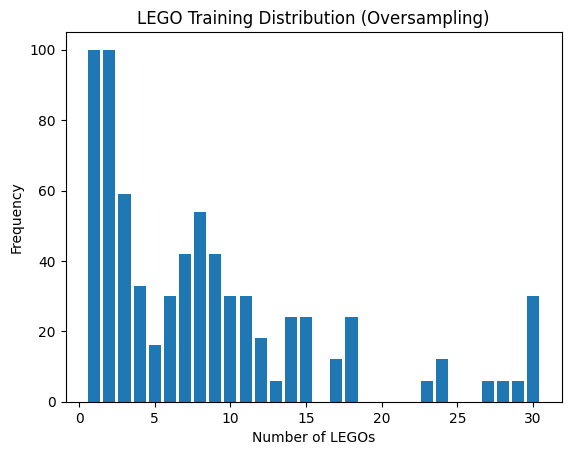

In [23]:
# oversampling of smaller classes in training data - augmentation

if apply_augmentation:
    new_image_paths, new_num_legos, new_bounding_boxes = generate_data(
                                                            image_paths[train_test_ids['train']],
                                                            num_legos[train_test_ids['train']],
                                                            train_boxes
                                                        )
    for img, lbl, bbox in zip(new_image_paths, new_num_legos, new_bounding_boxes):
        train_dataset.images_filenames = np.append(train_dataset.images_filenames, img)
        train_dataset.labels = torch.cat((train_dataset.labels, torch.tensor([lbl], dtype=torch.int64)))
        train_dataset.bounding_boxes.append(bbox)
    train_dataset.augmented.extend([1] * len(new_image_paths))
    num_legos_train = train_dataset.labels
    plt.hist(num_legos_train, bins=range(1, max(num_legos_train)), align='left', rwidth=0.8)
    plt.xlabel('Number of LEGOs')
    plt.ylabel('Frequency')
    plt.title('LEGO Training Distribution (Oversampling)')
    plt.show()

In [24]:
# dataloaders

batch_size = 8
num_workers = 2 if in_colab() else 0

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

len(train_dataset), len(valid_dataset), len(test_dataset)

(728, 137, 137)

### Faster R-CNN

#### Model definition

In [25]:
# get cpu or gpu device for training

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [26]:
# faster r-cnn model

faster_rcnn = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

in_features = faster_rcnn.roi_heads.box_predictor.cls_score.in_features
num_classes = 2
faster_rcnn.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 140MB/s]


In [27]:
# put model in device

model = faster_rcnn.to(device)

model

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

#### Model training

In [28]:
# possible strategies

train_only_head = True
train_head_and_rpn = True
train_all = True

In [29]:
def apply_nms(predictions, iou_threshold=0.3):
    """
    Apply non-maximum suppression to predictions
    """
    boxes = predictions['boxes']
    scores = predictions['scores']
    labels = predictions['labels']
    keep = torchvision.ops.nms(boxes, scores, iou_threshold=iou_threshold)
    boxes = boxes[keep]
    scores = scores[keep]
    labels = labels[keep]
    return boxes, scores, labels

In [30]:
def compute_map(preds, targets):
    """
    Calculates the Mean Average Precision (mAP) for object detection predictions
    """
    metric = MeanAveragePrecision(box_format='xyxy', iou_type='bbox')
    metric.update(preds=preds, target=targets)
    values = metric.compute()
    return values['map'].item()

In [31]:
def epoch_iter(dataloader, model, optimizer=None, is_train=True, grad_accum_steps=2):
    '''
    Perform one epoch of training/validation/testing
    '''
    if is_train:
        assert optimizer is not None, "When training, please provide an optimizer"
    num_batches = len(dataloader)
    model.train() if is_train else model.eval()
    total_loss = 0.0
    total_loss_classifier = 0.0
    total_loss_box_reg = 0.0
    total_loss_objectness = 0.0
    total_loss_rpn_box_reg = 0.0
    total_map = 0.0
    with torch.set_grad_enabled(is_train):
        for batch, (images, targets) in enumerate(tqdm(dataloader)):
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            if is_train:
                loss_data = model(images, targets)
                loss_classifier = loss_data['loss_classifier']
                total_loss_classifier += loss_classifier.item()
                loss_box_reg = loss_data['loss_box_reg']
                total_loss_box_reg += loss_box_reg.item()
                loss_objectness = loss_data['loss_objectness']
                total_loss_objectness += loss_objectness.item()
                loss_rpn_box_reg = loss_data['loss_rpn_box_reg']
                total_loss_rpn_box_reg += loss_rpn_box_reg.item()
                losses = (loss_classifier + loss_box_reg + loss_objectness + loss_rpn_box_reg) / grad_accum_steps
                optimizer.zero_grad()
                losses.backward()
                if (batch + 1) % grad_accum_steps == 0:
                    optimizer.step()
                total_loss += losses.item() * grad_accum_steps
            else:
                with torch.no_grad():
                    predictions = model(images)
                    for preds in predictions:
                        preds['boxes'], preds['scores'], preds['labels'] = apply_nms(preds)
                    map_score = compute_map(predictions, targets)
                    total_map += map_score
    avg_loss = total_loss / num_batches if is_train else None
    avg_loss_classifier = total_loss_classifier / num_batches if is_train else None
    avg_loss_box_reg = total_loss_box_reg / num_batches if is_train else None
    avg_loss_objectness = total_loss_objectness / num_batches if is_train else None
    avg_loss_rpn_box_reg = total_loss_rpn_box_reg / num_batches if is_train else None
    avg_map = total_map / num_batches if not is_train else None
    return {
        'avg_loss': avg_loss,
        'avg_loss_classifier': avg_loss_classifier,
        'avg_loss_box_reg': avg_loss_box_reg,
        'avg_loss_objectness': avg_loss_objectness,
        'avg_loss_rpn_box_reg': avg_loss_rpn_box_reg,
        'avg_map': avg_map
    }

In [32]:
def train(model, model_name, num_epochs, train_dataloader, validation_dataloader, optimizer, train_history=None, val_history=None):
    '''
    Train the model
    '''
    if train_history is None:
        train_history = {
            'loss': [],
            'loss_classifier': [],
            'loss_box_reg': [],
            'loss_objectness': [],
            'loss_rpn_box_reg': []
        }
    if val_history is None:
        val_history = {'map': []}
    best_val_map = -np.inf
    print("Start training...")
    for t in range(num_epochs):
        print(f"\nEpoch {t+1}/{num_epochs}")
        train_metrics = epoch_iter(train_dataloader, model, optimizer, is_train=True)
        train_loss = train_metrics['avg_loss']
        train_loss_classifier = train_metrics['avg_loss_classifier']
        train_loss_box_reg = train_metrics['avg_loss_box_reg']
        train_loss_objectness = train_metrics['avg_loss_objectness']
        train_loss_rpn_box_reg = train_metrics['avg_loss_rpn_box_reg']
        print(f"Train loss: {train_loss:.3f}")
        print(f"  Classifier loss: {train_loss_classifier:.3f}")
        print(f"  Box regression loss: {train_loss_box_reg:.3f}")
        print(f"  Objectness loss: {train_loss_objectness:.3f}")
        print(f"  RPN box regression loss: {train_loss_rpn_box_reg:.3f}")
        val_metrics = epoch_iter(validation_dataloader, model, is_train=False)
        val_map = val_metrics['avg_map']
        print(f"Validation mAP: {val_map:.3f}")
        if val_map > best_val_map:
            best_val_map = val_map
            save_dict = {
                'model': model.state_dict(),
                'optimizer': optimizer.state_dict(),
                'epoch': t
            }
            torch.save(save_dict, model_name + '_best.pth')
        save_dict = {
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'epoch': t
        }
        torch.save(save_dict, model_name + '_latest.pth')
        train_history['loss'].append(train_loss)
        train_history['loss_classifier'].append(train_loss_classifier)
        train_history['loss_box_reg'].append(train_loss_box_reg)
        train_history['loss_objectness'].append(train_loss_objectness)
        train_history['loss_rpn_box_reg'].append(train_loss_rpn_box_reg)
        val_history['map'].append(val_map)
    print("Finished")
    return train_history, val_history

In [33]:
# training and validation history

train_history = {
    'loss': [],
    'loss_classifier': [],
    'loss_box_reg': [],
    'loss_objectness': [],
    'loss_rpn_box_reg': []
}
val_history = {'map': []}

In [34]:
# model layers

for param in model.parameters():
    param.requires_grad = False

head_layers = ['roi_heads.box_predictor']
rpn_layers = [layer[0] for layer in list(model.named_parameters()) if 'rpn' in layer[0]]
backbone_layers = [layer[0] for layer in list(model.named_parameters()) if 'backbone' in layer[0]]

In [35]:
def unfreeze_layers(model, layers_to_unfreeze):
    '''
    Unfreeze the specified layers in the model
    '''
    for name, param in model.named_parameters():
        if any(layer in name for layer in layers_to_unfreeze):
            param.requires_grad = True

In [36]:
# train head

if train_only_head:
    unfreeze_layers(model, head_layers)
    optimizer = torch.optim.Adam(model.roi_heads.box_predictor.parameters(), lr=1e-3)
    num_epochs = 7
    train_history, val_history = train(
                                    model,
                                    'faster',
                                    num_epochs,
                                    train_dataloader,
                                    valid_dataloader,
                                    optimizer,
                                    train_history,
                                    val_history
                                )

Start training...

Epoch 1/7


100%|██████████| 91/91 [04:12<00:00,  2.77s/it]


Train loss: 0.821
  Classifier loss: 0.213
  Box regression loss: 0.295
  Objectness loss: 0.299
  RPN box regression loss: 0.013


100%|██████████| 18/18 [00:46<00:00,  2.56s/it]


Validation mAP: 0.565

Epoch 2/7


100%|██████████| 91/91 [04:10<00:00,  2.75s/it]


Train loss: 0.604
  Classifier loss: 0.112
  Box regression loss: 0.176
  Objectness loss: 0.301
  RPN box regression loss: 0.014


100%|██████████| 18/18 [00:47<00:00,  2.64s/it]


Validation mAP: 0.619

Epoch 3/7


100%|██████████| 91/91 [04:04<00:00,  2.68s/it]


Train loss: 0.584
  Classifier loss: 0.102
  Box regression loss: 0.171
  Objectness loss: 0.297
  RPN box regression loss: 0.013


100%|██████████| 18/18 [00:46<00:00,  2.58s/it]


Validation mAP: 0.630

Epoch 4/7


100%|██████████| 91/91 [04:11<00:00,  2.76s/it]


Train loss: 0.577
  Classifier loss: 0.098
  Box regression loss: 0.166
  Objectness loss: 0.300
  RPN box regression loss: 0.013


100%|██████████| 18/18 [00:47<00:00,  2.62s/it]


Validation mAP: 0.663

Epoch 5/7


100%|██████████| 91/91 [04:09<00:00,  2.74s/it]


Train loss: 0.572
  Classifier loss: 0.096
  Box regression loss: 0.160
  Objectness loss: 0.303
  RPN box regression loss: 0.013


100%|██████████| 18/18 [00:47<00:00,  2.66s/it]


Validation mAP: 0.667

Epoch 6/7


100%|██████████| 91/91 [04:18<00:00,  2.84s/it]


Train loss: 0.541
  Classifier loss: 0.091
  Box regression loss: 0.155
  Objectness loss: 0.282
  RPN box regression loss: 0.013


100%|██████████| 18/18 [00:47<00:00,  2.64s/it]


Validation mAP: 0.677

Epoch 7/7


100%|██████████| 91/91 [04:12<00:00,  2.77s/it]


Train loss: 0.557
  Classifier loss: 0.090
  Box regression loss: 0.154
  Objectness loss: 0.300
  RPN box regression loss: 0.013


100%|██████████| 18/18 [00:45<00:00,  2.54s/it]


Validation mAP: 0.672
Finished


In [38]:
# train head + RPN

if train_head_and_rpn:
    model = faster_rcnn.to(device)
    checkpoint = torch.load('faster_best.pth')
    model.load_state_dict(checkpoint['model'])
    del checkpoint
    unfreeze_layers(model, head_layers)
    unfreeze_layers(model, rpn_layers)
    optimizer = torch.optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4, momentum=0.9, weight_decay=0.0005)
    num_epochs = 3
    train_history, val_history = train(
                                    model,
                                    'faster',
                                    num_epochs,
                                    train_dataloader,
                                    valid_dataloader,
                                    optimizer,
                                    train_history,
                                    val_history
                                )

Start training...

Epoch 1/3


100%|██████████| 91/91 [04:23<00:00,  2.90s/it]


Train loss: 0.512
  Classifier loss: 0.093
  Box regression loss: 0.152
  Objectness loss: 0.254
  RPN box regression loss: 0.012


100%|██████████| 18/18 [00:48<00:00,  2.68s/it]


Validation mAP: 0.683

Epoch 2/3


100%|██████████| 91/91 [04:13<00:00,  2.79s/it]


Train loss: 0.411
  Classifier loss: 0.097
  Box regression loss: 0.152
  Objectness loss: 0.151
  RPN box regression loss: 0.011


100%|██████████| 18/18 [00:45<00:00,  2.54s/it]


Validation mAP: 0.685

Epoch 3/3


100%|██████████| 91/91 [04:14<00:00,  2.79s/it]


Train loss: 0.362
  Classifier loss: 0.099
  Box regression loss: 0.152
  Objectness loss: 0.100
  RPN box regression loss: 0.011


100%|██████████| 18/18 [00:45<00:00,  2.55s/it]


Validation mAP: 0.687
Finished


In [ ]:
# train head + RPN + backbone

if train_all:
    torch.cuda.empty_cache()
    model = faster_rcnn.to(device)
    checkpoint = torch.load('faster_best.pth')
    model.load_state_dict(checkpoint['model'])
    del checkpoint
    unfreeze_layers(model, head_layers)
    unfreeze_layers(model, rpn_layers)
    unfreeze_layers(model, backbone_layers)
    for param in model.parameters():
        param.requires_grad = True
    optimizer = torch.optim.SGD(model.parameters(), lr=1e-4, momentum=0.9, weight_decay=0.0005)
    num_epochs = 20
    train_history, val_history = train(
                                    model,
                                    'faster',
                                    num_epochs,
                                    train_dataloader,
                                    valid_dataloader,
                                    optimizer,
                                    train_history,
                                    val_history
                                )

#### Training evolution analysis

In [ ]:
def plotTrainingLoss(train_history):
    '''
    Plot the training loss history of the model
    '''
    plt.figure(figsize=(10, 4))
    plt.plot(train_history['loss'], label='Training Loss')
    plt.plot(train_history['loss_classifier'], label='Classifier Loss')
    plt.plot(train_history['loss_box_reg'], label='Box Regression Loss')
    plt.plot(train_history['loss_objectness'], label='Objectness Loss')
    plt.plot(train_history['loss_rpn_box_reg'], label='RPN Box Regression Loss')
    plt.title('Training Loss History')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [ ]:
# visualize training history

plotTrainingLoss(train_history)

In [ ]:
def plotValidationMAP(val_history):
    '''
    Plot the validation mAP history of the model
    '''
    plt.figure(figsize=(10, 4))
    plt.plot(val_history['map'], label='Validation mAP')
    plt.title('Validation mAP History')
    plt.xlabel('Epochs')
    plt.ylabel('mAP')
    plt.legend()
    plt.show()

In [ ]:
# visualize validation history

plotValidationMAP(val_history)

#### Model testing

In [ ]:
# load best model

model = faster_rcnn.to(device)
checkpoint = torch.load('faster_best.pth')
model.load_state_dict(checkpoint['model'])
del checkpoint

In [ ]:
# evaluate model on test data

test_metrics = epoch_iter(test_dataloader, model, is_train=False)
test_map = test_metrics['avg_map']
print(f"\nTest mAP: {test_map:.3f}")

In [ ]:
def show_predictions(model, dataloader, num_images=20):
    '''
    Display ground truth vs prediction in images
    '''
    model.eval()
    image_count = 0
    for batch, (images, targets) in enumerate(dataloader):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        with torch.no_grad():
            predictions = model(images)
            for i in range(len(images)):
                fig, axes = plt.subplots(1, 2, figsize=(8, 4))
                axes[0].imshow(transforms.ToPILImage()(images[i]))
                axes[0].set_title('True')
                axes[0].axis('off')
                for box in targets[i]['boxes']:
                    box = box.cpu().numpy()
                    rect = patches.Rectangle(
                        (box[0], box[1]),
                        box[2] - box[0],
                        box[3] - box[1],
                        linewidth=2,
                        edgecolor='g',
                        facecolor='none'
                    )
                    axes[0].add_patch(rect)
                axes[1].imshow(transforms.ToPILImage()(images[i]))
                axes[1].set_title('Predicted')
                axes[1].axis('off')
                boxes, scores, labels = apply_nms(predictions[i])
                for box, score, label in zip(boxes, scores, labels):
                    if score > 0.5:
                        box = box.cpu().numpy()
                        rect = patches.Rectangle(
                            (box[0], box[1]),
                            box[2] - box[0],
                            box[3] - box[1],
                            linewidth=2,
                            edgecolor='b',
                            facecolor='none'
                        )
                        axes[1].add_patch(rect)
                        axes[1].text(box[0], box[1], f'{score:.2f}', bbox=dict(facecolor='yellow', alpha=0.5))
                plt.show()
                image_count += 1
                if image_count >= num_images:
                    break
        if image_count >= num_images:
            break

In [ ]:
# view predictions

show_predictions(model, test_dataloader)

In [ ]:
# delete model data

del model
torch.cuda.empty_cache()

### YOLO

#### Data preparation

In [48]:
# data folder

data_folder = '/content/datasets' if in_colab() else 'datasets'

In [49]:
def populate_folder(dataloader, folder):
    '''
    Populate a folder with images and labels
    '''
    for i, (images, targets) in enumerate(tqdm(dataloader)):
        for j, image in enumerate(images):
            img = F.to_pil_image(image)
            img.save(os.path.join(folder, 'images', f'{i}_{j}.jpg'))
            with open(os.path.join(folder, 'labels', f'{i}_{j}.txt'), 'w') as f:
                for box in targets[j]['boxes']:
                    x_min, y_min, x_max, y_max = box
                    x_center = (x_min + x_max) / 2.0 / 640
                    y_center = (y_min + y_max) / 2.0 / 640
                    width = (x_max - x_min) / 640
                    height = (y_max - y_min) / 640
                    f.write(f'0 {x_center} {y_center} {width} {height}\n')

In [50]:
# create folders for train, valid, and test sets

os.makedirs(data_folder + '/train/images', exist_ok=True)
os.makedirs(data_folder + '/train/labels', exist_ok=True)
populate_folder(train_dataloader, data_folder + '/train')

os.makedirs(data_folder + '/val/images', exist_ok=True)
os.makedirs(data_folder + '/val/labels', exist_ok=True)
populate_folder(valid_dataloader, data_folder + '/val')

os.makedirs(data_folder + '/test/images', exist_ok=True)
os.makedirs(data_folder + '/test/labels', exist_ok=True)
populate_folder(test_dataloader, data_folder + '/test')

100%|██████████| 18/18 [00:28<00:00,  1.59s/it]


In [51]:
# create data.yaml file

data_yaml = None

if in_colab():
    data_yaml = """
    names:
        0: Lego
    nc: 1
    train: /content/datasets/train/images
    val: /content/datasets/val/images
    test: /content/datasets/test/images
    """
    with open('/content/data.yaml', 'w') as f:
        f.write(data_yaml)
else:
    data_yaml = """
    names:
        0: Lego
    nc: 1
    train: train/images
    val: val/images
    test: test/images
    """
    with open('data.yaml', 'w') as f:
        f.write(data_yaml)

#### Model training

In [52]:
# phase 1 - initial training with the first 10 layers frozen

if in_colab():
    !yolo task=detect mode=train model=yolov8s.pt data='/content/data.yaml' epochs=10 imgsz=640 name=yoloV8SLego_phase1 batch=8 freeze=10
else:
    !yolo task=detect mode=train model=yolov8s.pt data='data.yaml' epochs=10 imgsz=640 name=yoloV8SLego_phase1 batch=8 freeze=10

100% 21.5M/21.5M [00:00<00:00, 163MB/s]
New https://pypi.org/project/ultralytics/8.2.31 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.2.30 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/content/data.yaml, epochs=10, time=None, patience=100, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=yoloV8SLego_phase1, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=10, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_ma

In [53]:
# phase 2 - unfreeze 5 layers and continue training

if in_colab():
    !yolo task=detect mode=train model=runs/detect/yoloV8SLego_phase1/weights/last.pt data='/content/data.yaml' epochs=10 imgsz=640 name=yoloV8SLego_phase2 batch=8 freeze=5
else:
    !yolo task=detect mode=train model=runs/detect/yoloV8SLego_phase1/weights/last.pt data='data.yaml' epochs=10 imgsz=640 name=yoloV8SLego_phase2 batch=8 freeze=5

New https://pypi.org/project/ultralytics/8.2.31 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.2.30 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=runs/detect/yoloV8SLego_phase1/weights/last.pt, data=/content/data.yaml, epochs=10, time=None, patience=100, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=yoloV8SLego_phase2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=5, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=F

In [54]:
# phase 3 - unfreeze all layers and finalize training

if in_colab():
    !yolo task=detect mode=train model=runs/detect/yoloV8SLego_phase2/weights/last.pt data='/content/data.yaml' epochs=10 imgsz=640 name=yoloV8SLego_phase3 batch=8 freeze=0
else:
    !yolo task=detect mode=train model=runs/detect/yoloV8SLego_phase2/weights/last.pt data='data.yaml' epochs=10 imgsz=640 name=yoloV8SLego_phase3 batch=8 freeze=0

New https://pypi.org/project/ultralytics/8.2.31 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.2.30 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=runs/detect/yoloV8SLego_phase2/weights/last.pt, data=/content/data.yaml, epochs=10, time=None, patience=100, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=yoloV8SLego_phase3, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=0, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=F

#### Training evolution analysis

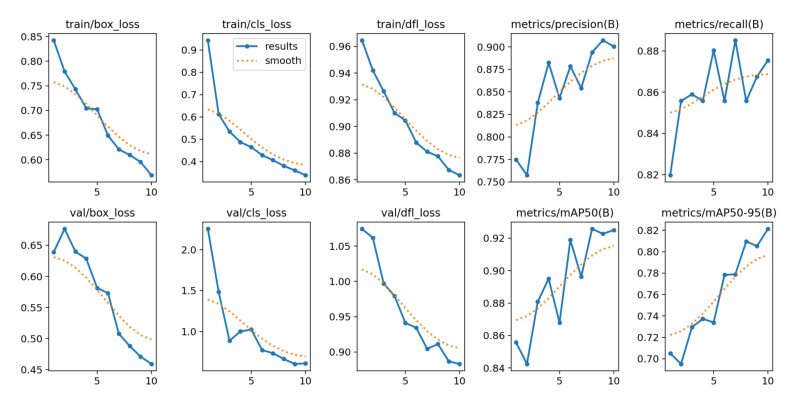

In [55]:
# visualize training and validation history - phase 1

history = '/content/runs/detect/yoloV8SLego_phase1/results.png' if in_colab() else 'runs/detect/yoloV8SLego_phase1/results.png'
img = cv2.imread(history)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.axis('off')
plt.show()

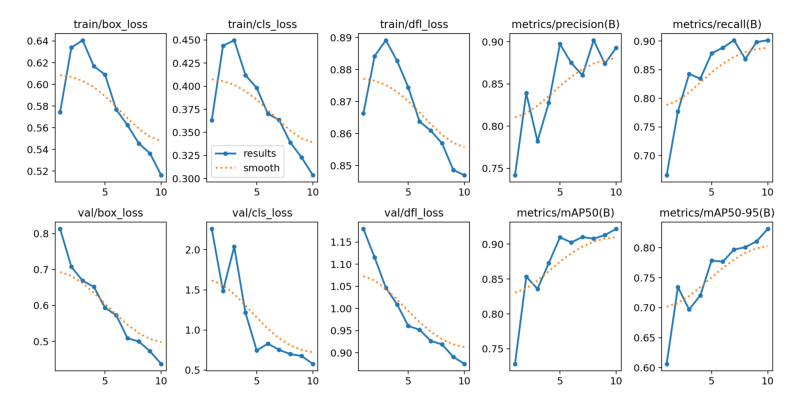

In [56]:
# visualize training and validation history - phase 2

history = '/content/runs/detect/yoloV8SLego_phase2/results.png' if in_colab() else 'runs/detect/yoloV8SLego_phase2/results.png'
img = cv2.imread(history)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.axis('off')
plt.show()

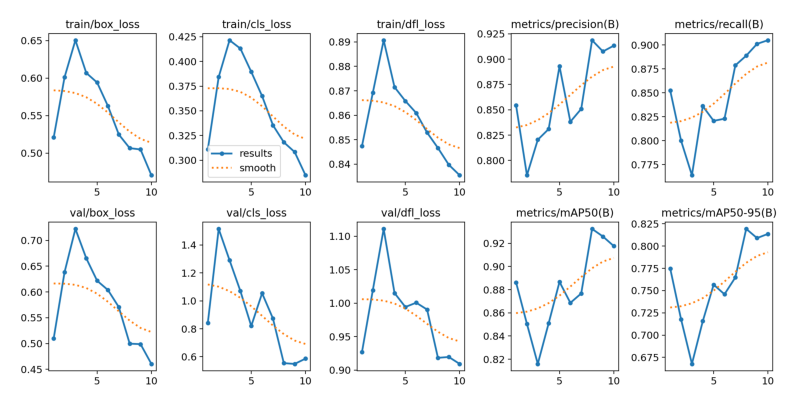

In [57]:
# visualize training and validation history - phase 3

history = '/content/runs/detect/yoloV8SLego_phase3/results.png' if in_colab() else 'runs/detect/yoloV8SLego_phase3/results.png'
img = cv2.imread(history)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.axis('off')
plt.show()

#### Model testing

In [58]:
# update data.yaml file - use test images

data_yaml = None

if in_colab():
    data_yaml = """
    names:
        0: Lego
    nc: 1
    train: /content/datasets/train/images
    val: /content/datasets/test/images
    test: /content/datasets/val/images
    """
    with open('/content/data.yaml', 'w') as f:
        f.write(data_yaml)
else:
    data_yaml = """
    names:
        0: Lego
    nc: 1
    train: train/images
    val: test/images
    test: val/images
    """
    with open('data.yaml', 'w') as f:
        f.write(data_yaml)

In [59]:
# evaluation metrics

if in_colab():
    !yolo task=detect mode=val model=runs/detect/yoloV8SLego_phase3/weights/best.pt name=yolov8Lego_eval data='/content/data.yaml' imgsz=640
else:
    !yolo task=detect mode=val model=runs/detect/yoloV8SLego_phase3/weights/best.pt name=yolov8Lego_eval data='data.yaml' imgsz=640

Ultralytics YOLOv8.2.30 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 11125971 parameters, 0 gradients, 28.4 GFLOPs
val: Scanning /content/datasets/test/labels... 137 images, 0 backgrounds, 0 corrupt: 100% 137/137 [00:00<00:00, 772.95it/s]
val: New cache created: /content/datasets/test/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 9/9 [00:04<00:00,  2.02it/s]
                   all        137        309      0.908      0.899      0.946      0.822
Speed: 2.6ms preprocess, 12.2ms inference, 0.0ms loss, 7.1ms postprocess per image
Results saved to runs/detect/yolov8Lego_eval
💡 Learn more at https://docs.ultralytics.com/modes/val


In [60]:
# predictions

if in_colab():
    !yolo task=detect mode=predict model=runs/detect/yoloV8SLego_phase3/weights/best.pt name=yolov8Lego_test source="/content/datasets/test/images" imgsz=640
else:
    !yolo task=detect mode=predict model=runs/detect/yoloV8SLego_phase3/weights/best.pt name=yolov8Lego_test source="datasets/test/images" imgsz=640

Ultralytics YOLOv8.2.30 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 11125971 parameters, 0 gradients, 28.4 GFLOPs

image 1/137 /content/datasets/test/images/0_0.jpg: 640x640 2 Legos, 16.3ms
image 2/137 /content/datasets/test/images/0_1.jpg: 640x640 1 Lego, 16.4ms
image 3/137 /content/datasets/test/images/0_2.jpg: 640x640 1 Lego, 16.3ms
image 4/137 /content/datasets/test/images/0_3.jpg: 640x640 1 Lego, 16.3ms
image 5/137 /content/datasets/test/images/0_4.jpg: 640x640 1 Lego, 16.3ms
image 6/137 /content/datasets/test/images/0_5.jpg: 640x640 1 Lego, 16.2ms
image 7/137 /content/datasets/test/images/0_6.jpg: 640x640 1 Lego, 16.2ms
image 8/137 /content/datasets/test/images/0_7.jpg: 640x640 1 Lego, 13.4ms
image 9/137 /content/datasets/test/images/10_0.jpg: 640x640 (no detections), 13.4ms
image 10/137 /content/datasets/test/images/10_1.jpg: 640x640 4 Legos, 13.4ms
image 11/137 /content/datasets/test/images/10_2.jpg: 640x640 1 Lego, 13.4ms
i

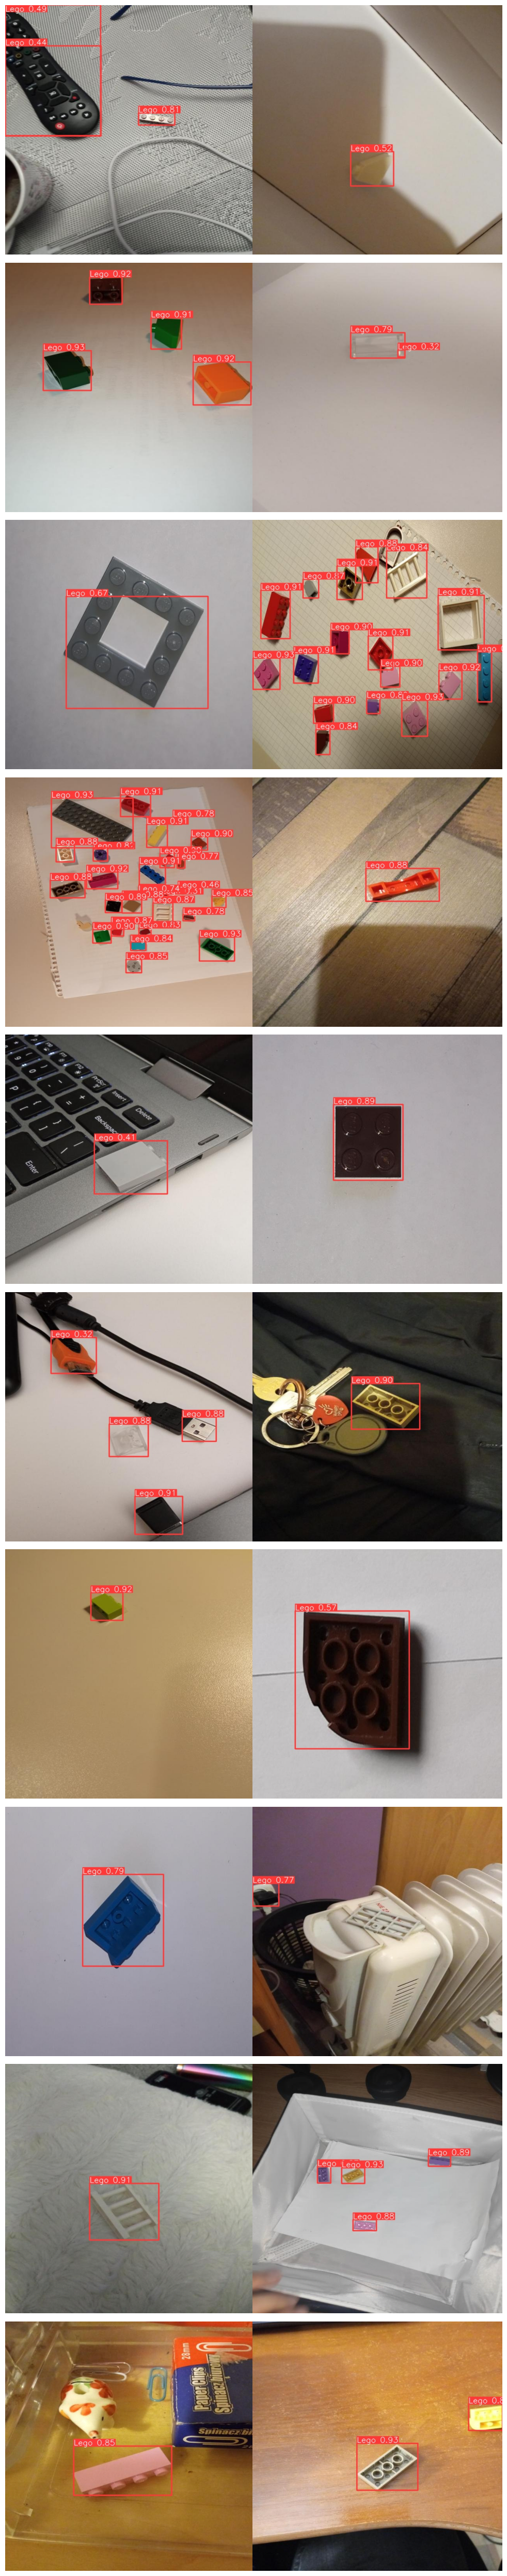

In [61]:
# show some predictions

folder_path = '/content/runs/detect/yolov8Lego_test' if in_colab() else 'runs/detect/yolov8Lego_test'
file_list = os.listdir(folder_path)
num_images_to_display = 20
num_cols = 2
num_rows = (num_images_to_display + num_cols - 1) // num_cols
fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 5*num_rows))

for i in range(num_images_to_display):
    image_path = os.path.join(folder_path, file_list[i])
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    row_idx = i // num_cols
    col_idx = i % num_cols
    axes[row_idx, col_idx].imshow(image_rgb)
    axes[row_idx, col_idx].axis('off')
plt.tight_layout()
plt.show()

# LEGO Segmentation

In [62]:
# auto annotation - bounding boxes from trained model to segment images

if in_colab():
    auto_annotate(data="/content/datasets/test/images", det_model='/content/runs/detect/yoloV8SLego_phase3/weights/best.pt', sam_model="sam_b.pt")
else:
    auto_annotate(data="datasets/test/images", det_model='runs/detect/yoloV8SLego_phase3/weights/best.pt', sam_model="sam_b.pt")

100%|██████████| 358M/358M [00:01<00:00, 251MB/s]



image 1/137 /content/datasets/test/images/0_0.jpg: 640x640 2 Legos, 16.2ms
image 2/137 /content/datasets/test/images/0_1.jpg: 640x640 1 Lego, 8.3ms
image 3/137 /content/datasets/test/images/0_2.jpg: 640x640 1 Lego, 12.4ms
image 4/137 /content/datasets/test/images/0_3.jpg: 640x640 1 Lego, 14.2ms
image 5/137 /content/datasets/test/images/0_4.jpg: 640x640 1 Lego, 12.4ms
image 6/137 /content/datasets/test/images/0_5.jpg: 640x640 1 Lego, 12.6ms
image 7/137 /content/datasets/test/images/0_6.jpg: 640x640 1 Lego, 13.0ms
image 8/137 /content/datasets/test/images/0_7.jpg: 640x640 1 Lego, 12.3ms
image 9/137 /content/datasets/test/images/10_0.jpg: 640x640 (no detections), 13.5ms
image 10/137 /content/datasets/test/images/10_1.jpg: 640x640 4 Legos, 10.2ms
image 11/137 /content/datasets/test/images/10_2.jpg: 640x640 1 Lego, 13.2ms
image 12/137 /content/datasets/test/images/10_3.jpg: 640x640 (no detections), 15.9ms
image 13/137 /content/datasets/test/images/10_4.jpg: 640x640 1 Lego, 11.8ms
image 14/

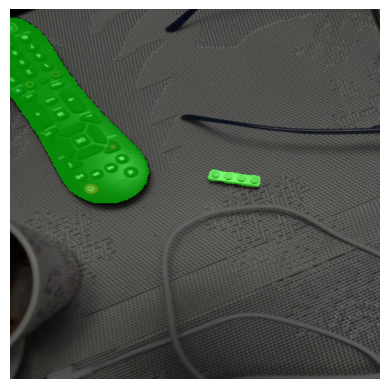

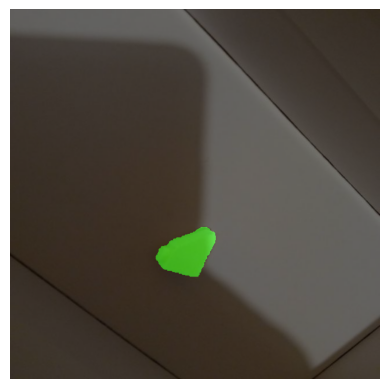

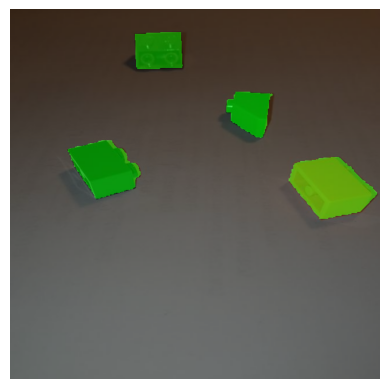

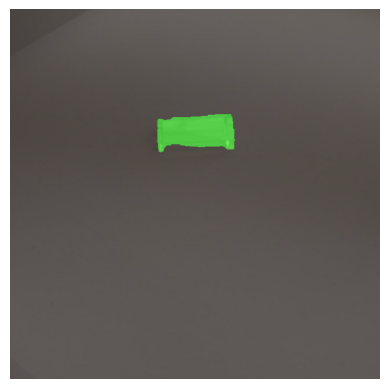

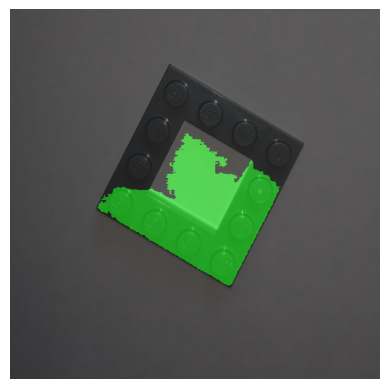

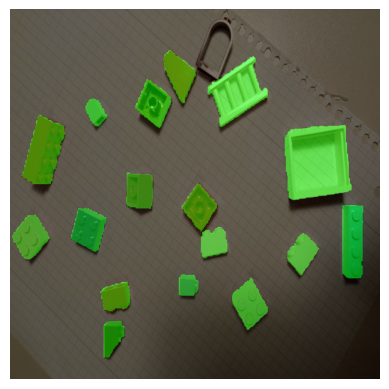

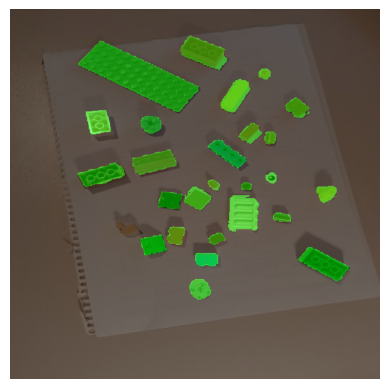

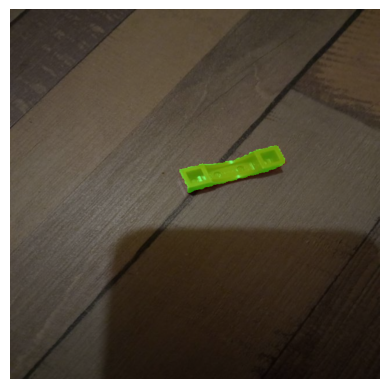

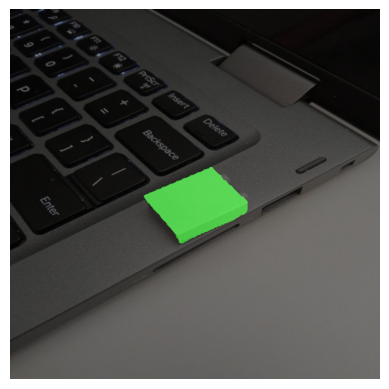

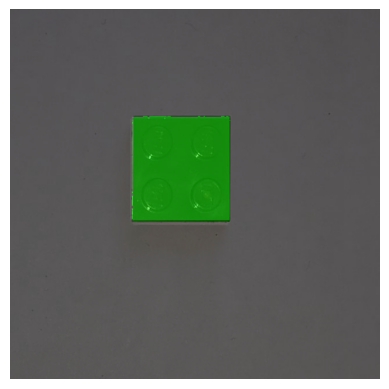

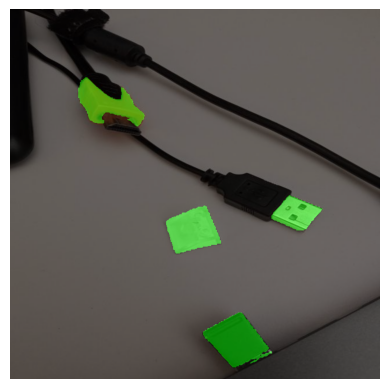

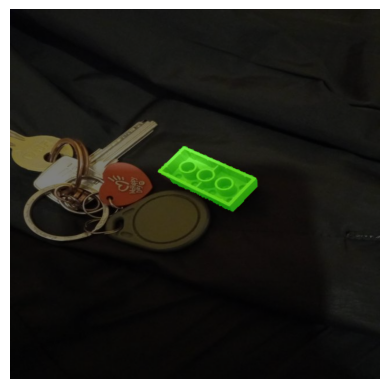

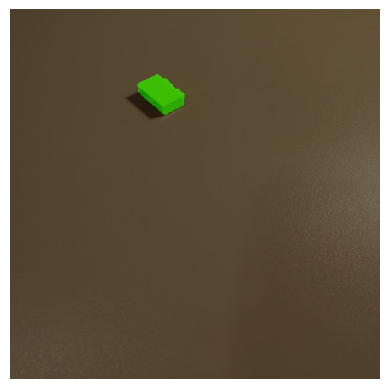

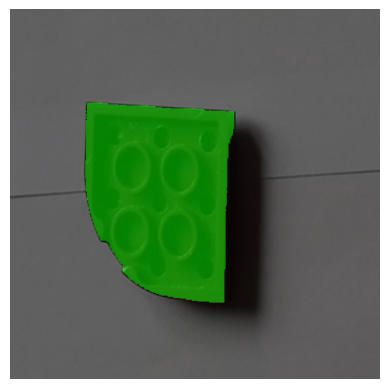

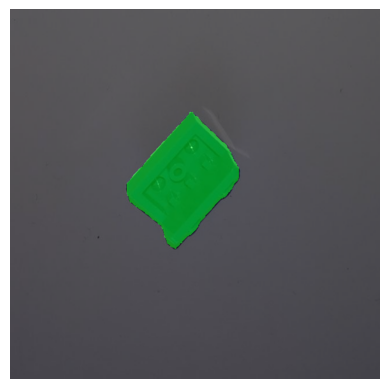

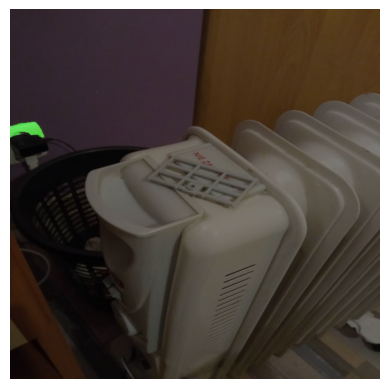

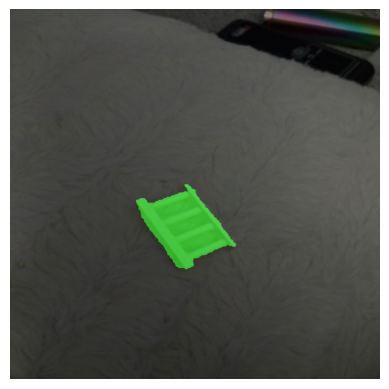

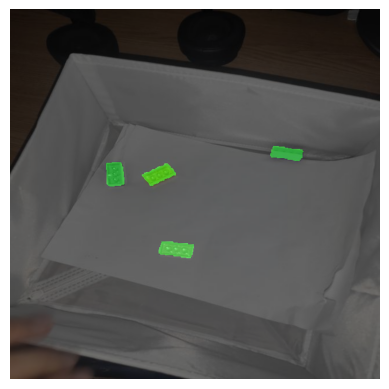

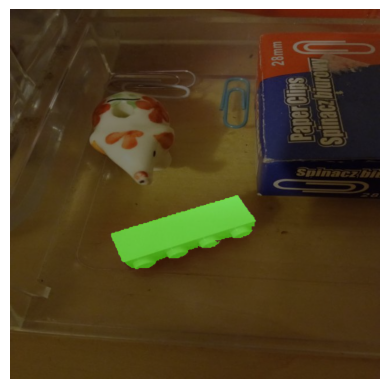

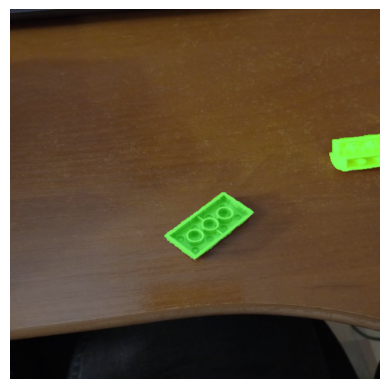

In [66]:
# visualize some images with segmentation

images_folder = "/content/datasets/test/images" if in_colab() else "datasets/test/images"
annotations_folder = "/content/datasets/test/images_auto_annotate_labels" if in_colab() else "datasets/test/images_auto_annotate_labels"
image_files = os.listdir(images_folder)[:20]

for image_file in image_files:
    image_path = os.path.join(images_folder, image_file)
    image = Image.open(image_path)
    annotation_file = os.path.splitext(image_file)[0] + ".txt"
    annotations_path = os.path.join(annotations_folder, annotation_file)
    if os.path.exists(annotations_path):
        with open(annotations_path, 'r') as file:
            annotations = file.readlines()
    else:
        annotations = []
    mask = np.zeros_like(image)
    for line in annotations:
        line = line.strip().split()
        class_id = int(line[0])
        points = [(float(line[i]), float(line[i+1])) for i in range(1, len(line), 2)]
        points = [(int(p[0] * image.width), int(p[1] * image.height)) for p in points]
        mask = cv2.fillPoly(mask, [np.array(points)], (0, 255, 0))
    mask_pil = Image.fromarray(mask)
    merged_image = Image.blend(image, mask_pil, alpha=0.5)
    plt.imshow(merged_image)
    plt.axis('off')
    plt.show()